In [2]:
import pandas
import os
import itertools
import numpy as np
import nibabel as ni
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from glob import glob
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import model_selection, linear_model
from sklearn import mixture
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score
from nilearn import image, plotting
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import calinski_harabaz_score
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from mpl_toolkits.mplot3d import Axes3D

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [3]:
def PCA_LR_pipeline(in_mtx, y, pca = PCA(random_state=123), 
                    clf = linear_model.LassoCV(random_state = 123), 
                    cv_strategy = None, cv = 10, test_gene_num = [100], illustrative = False,
                   sanity_check_style = 'separate', cv_labels = [], reverse_axes = True):
    
    final_outputs = {}
    
    if type(in_mtx) == pandas.core.frame.DataFrame:
        in_mtx = in_mtx.values
    
    if type(pca) == type(None):
        pca_tfm = in_mtx
    else:
        print('running PCA')
        dat_pca = pca.fit(in_mtx)
        print('transforming data')
        pca_tfm = dat_pca.transform(in_mtx)
        #if len(y) != pca_tfm.shape[-1]:
        #    raise ValueError('length of y-axis of transformed item must match the length of y')
        final_outputs.update({'pca_object': dat_pca})
    
    
    print('performing model cross-validation')
    if hasattr(cv_strategy, 'get_n_splits'):
        folds = cv_strategy.get_n_splits(pca_tfm)
        #scores = model_selection.cross_val_score(clf, pca_tfm, y=y, groups=folds, cv=cv)
        predicted = model_selection.cross_val_predict(clf, pca_tfm, y=y, groups=folds, cv=cv)
        observed = y
        score = stats.pearsonr(predicted, y)[0]**2
    elif cv_strategy == 'LOLO':
        print('using leave-one-label-out cross-validation')
        observed, predicted = leave_one_x_out(cv_labels, pca_tfm, y, clf)
        score = stats.pearsonr(predicted,observed)[0]**2
    elif cv_strategy == 'balanced':
        print('balancing cross-validation by labels')
        observed, predicted = balanced_cv(cv_labels, pca_tfm, y, clf, cv)
        score = stats.pearsonr(predicted,observed)[0]**2
    elif type(cv_strategy) == int:
        print('using %s iterations of %s-fold cross-validation'%(cv_strategy,cv))
        score = []
        preds = np.zeros((cv_strategy,len(y)))
        for i in range(cv_strategy):
            sel = model_selection.KFold(n_splits=cv, shuffle=True)
            predicted = model_selection.cross_val_predict(clf, pca_tfm, y=y, cv=sel)
            preds[i,:] = predicted
            score.append(stats.pearsonr(predicted, y)[0]**2)
            print('completed iteration',i+1)
    elif type(cv_strategy) != type(None):
        print('using basic %s-fold cross-validation'%cv)
        #scores = model_selection.cross_val_score(clf, pca_tfm, y=y, cv=cv)
        predicted = model_selection.cross_val_predict(clf, pca_tfm, y=y, cv=cv)
        observed = y
        try:
            score = stats.pearsonr(predicted, y)[0]**2
        except:
            score = stats.pearsonr(predicted[:,0], y)[0]**2
    else:
        score = None
    if type(score) != type(None):
        if type(score) == list:
            if illustrative:
                plt.close()
                sns.regplot(preds.mean(0), y, fit_reg=False)
                plt.xlabel('Average CV model predicted position along axis')
                plt.ylabel('Actual position along axis')
                plt.show()

                jnk = pandas.DataFrame(index = range(cv_strategy+1), 
                                       columns = ['score','iteration'])
                jnk.loc[:,'iteration'] = list(range(cv_strategy)) + ['mean']
                jnk.loc[:,'score'] = score + [np.mean(score)]
                plt.close()
                sns.factorplot(x='iteration',y='score',data=jnk)
                plt.show()
                print('model cv scores (r2):')
                print(score)
                print('average r2:',np.mean(score))
                final_outputs.update({'CV_scores': score})
        else:        
            if illustrative:
                plt.close()
                sns.regplot(predicted, observed, fit_reg=False)
                plt.xlabel('CV model predicted position along axis')
                plt.ylabel('Actual position along axis')
                plt.show()
            print('model cv score: r2 = ',score)
            final_outputs.update({'CV_scores': score})
    else:
        print('no valid cross-validation method specified')
    
    print('running final model')
    mod = clf.fit(pca_tfm, y)
    if not hasattr(mod,'coef_'):
        raise IOError('right now, this pipeline can only accept clf objects with a coef_ attribute')
    final_outputs.update({'final_model': mod})
    scr = mod.score(pca_tfm, y)
    print('final model fit r2 = ',scr)
    if illustrative:
        plt.close()
        sns.regplot(x=mod.predict(pca_tfm), y=y)
        plt.xlabel('Model predicted position along A-P axis')
        plt.ylabel('Actual position along A-P axis')
        plt.show()
    
    if type(pca) == type(None):
        f_betas = mod.coef_
    else:
        f_betas = back_transform(dat_pca, mod)
    final_outputs.update({'betas': f_betas})
    
    gene_selections = sanity_check(in_mtx, y, f_betas, test_gene_num, 
                                   illustrative, sanity_check_style, reverse_axes)
    final_outputs.update({'gene_selections': gene_selections})
    
    return final_outputs
    
def back_transform(pca_obj, clf_obj):
    return np.dot(pca_obj.components_.T,clf_obj.coef_)

def sanity_check(in_mtx, y, betas, test_gene_num, illustrative, 
                 sanity_check_style, reverse_axes):
    
    if sanity_check_style == 'separate':
        ascores = []
        pscores = []
    else:
        scores = []
    print('running sanity_check')
    try:
        betas = pandas.Series(betas)
    except:
        betas = pandas.Series(betas[:,0])
    outputs = {}
    for num in test_gene_num:
      
        p_chk = betas.sort_values(ascending=False)[:num].index
        a_chk = betas.sort_values(ascending=False)[-num:].index

        pchk_vals = []
        achk_vals = []
        
        for sample in range(in_mtx.shape[0]):
            to_avg = []
            for gene in p_chk:
                to_avg.append(in_mtx[sample,gene])
            if sanity_check_style == 'model':
                pchk_vals.append(np.mean(np.array(to_avg) * betas.loc[p_chk].values))
            else:
                pchk_vals.append(np.mean(to_avg))
        
        for sample in range(in_mtx.shape[0]):
            to_avg = []
            for gene in a_chk:
                to_avg.append(in_mtx[sample,gene])
            if sanity_check_style == 'separate':
                achk_vals.append(np.mean(to_avg))
            elif sanity_check_style == 'model':
                achk_vals.append(np.mean(np.array(to_avg) * betas.loc[a_chk].values))
            else:
                achk_vals.append(np.mean(to_avg) * -1)

        if sanity_check_style != 'separate':
            chk_vals = np.array(pchk_vals) + np.array(achk_vals)
            
        if sanity_check_style == 'separate':
            pr,pp = stats.pearsonr(pchk_vals, y)
            if illustrative:
                plt.close()
                sns.regplot(x=np.array(pchk_vals), y=y, fit_reg=None)
                if reverse_axes:
                    plt.xlabel('expression of anterior direction genes')
                    plt.ylabel('location along hippocampus (anterior = higher)')
                    plt.show()
                    print('anterior %s genes vs. y:  r2 = %s, p = %s \n\n'%(num, pr**2, pp))
                else:
                    plt.xlabel('expression of posterior direction genes')
                    plt.ylabel('location along hippocampus (posterior = higher)')
                    plt.show()
                    print('posterior %s genes vs. y:  r2 = %s, p = %s \n\n'%(num, pr**2, pp))

            ar,ap = stats.pearsonr(achk_vals, y)
            if illustrative:
                plt.close()
                sns.regplot(x=np.array(achk_vals), y=y, fit_reg=None)
                if reverse_axes:
                    plt.xlabel('expression of posterior direction genes')
                    plt.ylabel('location along hippocampus (anterior = higher)')
                    plt.show()
                    print('posterior %s genes vs. y:  r2 = %s, p = %s \n\n'%(num, ar**2, ap))
                else:
                    plt.xlabel('expression of anterior direction genes')
                    plt.ylabel('location along hippocampus (posterior = higher)')
                    plt.show()
                    print('anterior %s genes vs. y:  r2 = %s, p = %s \n\n'%(num, ar**2, ap))
            
        else:
            r,p = stats.pearsonr(chk_vals, y)
            if illustrative:
                plt.close()
                sns.regplot(x=np.array(chk_vals), y=y, fit_reg=None)
                plt.xlabel('expression of A-P axis genes')
                if reverse_axes:
                    plt.ylabel('location along hippocampus (anterior = higher)')
                else:
                    plt.ylabel('location along hippocampus (posterior = higher)')
                plt.show()
                print('posterior and anterior %s genes vs. y:  r2 = %s, p = %s \n\n'%(
                                                                                num, r**2, p))
            
        if sanity_check_style == 'separate':
            if reverse_axes:
                ascores.append(pr**2)
                pscores.append(ar**2)
            else:
                ascores.append(ar**2)
                pscores.append(pr**2)
        else:
            scores.append(r**2)
        if reverse_axes:
            outputs.update({'posterior_genes_%s'%num: a_chk}) 
            outputs.update({'anterior_genes_%s'%num: p_chk})
        else:
            outputs.update({'posterior_genes_%s'%num: p_chk}) 
            outputs.update({'anterior_genes_%s'%num: a_chk})
            
    if len(test_gene_num) > 1:
        if sanity_check_style == 'separate':
            jnk = pandas.concat([pandas.Series(test_gene_num), 
                                 pandas.Series(ascores),
                                pandas.Series(pscores)],axis=1)
            jnk.columns = ['num','a','p']

            plt.close()
            fig,(ax1,ax2) = plt.subplots(2, figsize=(8,10))
            sns.factorplot(x='num', y='a', data=jnk, ax=ax1)
            sns.factorplot(x='num', y='p', data=jnk, ax=ax2)
            ax1.set(xlabel = 'Number of posterior genes', 
                    ylabel ='Explained variance in \nhippocampus a-p gradient')
            ax2.set(xlabel = 'Number of anterior genes', 
                    ylabel ='Explained variance in \nhippocampus a-p gradient')
            plt.show()
        else:
            jnk = pandas.concat([pandas.Series(test_gene_num), 
                                 pandas.Series(scores)
                                ],axis=1)
            jnk.columns = ['num','score']

            plt.close()
            fig,ax1 = plt.subplots(1, figsize=(8,10))
            sns.factorplot(x='num', y='score', data=jnk, ax=ax1)
            ax1.set(xlabel = 'Number of genes', 
                    ylabel ='Explained variance in \nhippocampus a-p gradient')
            plt.show()

    return outputs

def leave_one_x_out(labels, in_X, in_y, clf):

    obsz = []
    predz = []
    label_map = dict(zip(labels.unique(), range(len(labels.unique()))))
    labels = [label_map[x] for x in labels]
    for label in np.unique(labels):
        Tr_samps = [i for i in labels if labels[i] != label]
        Te_samps = [i for i in labels if labels[i] == label]
        X = in_X[Tr_samps,:]
        in_y = y.iloc[Tr_samps]
        mod = clf.fit(X,y)
        pred = mod.predict(in_X[Te_samps,:])
        for x in range(len(pred)):
            obsz.append(y.values[x])
            predz.append(pred[x])
    
    return obsz, predz

def balanced_cv(labels, in_X, in_y, clf, cv):
    
    obsz = []
    predz = []
    tst = model_selection.StratifiedKFold(n_splits=cv, random_state=123)
    label_map = dict(zip(labels.unique(), range(len(labels.unique()))))
    labels = [label_map[x] for x in labels]
    for tr_idx, te_idx in tst.split(in_X, labels):
        X = in_X[tr_idx,:]
        y = in_y.loc[tr_idx]
        mod = clf.fit(X,y)
        pred = mod.predict(in_X[te_idx,:])
        for i in range(len(predz)):
            obsz.append(y.values[x])
            predz.append(pred[i])
            
    return obsz, predz

In [4]:
def convert_coords(coord, to_what = 'mni', vs = 1):
    origin = [90, 126, 72]
    origin = (np.array(origin) / vs).astype(int).tolist()
    x,y,z = coord[0],coord[1],coord[2]
    
    if to_what == 'mni':
        x = (origin[0]-x)*vs
        y = (y-origin[1])*vs
        z = (z-origin[2])*vs
        
    elif to_what == 'xyz':
        x=origin[0]- x/vs
        y=y/vs + origin[1]
        z=z/vs + origin[2]
        
    else:
        raise IOError('please set to_what to either mni or xyz')
    
    return x,y,z

In [5]:
def make_sphere(coord, radius):
    summers = []
    negrad = (radius*-1)+1
    for x in itertools.product(range(negrad,radius),repeat=3):
        summers.append(np.array(x))
    s_coords = [np.array(coord) + x for x in summers]
    xs = [int(x[0]) for x in s_coords]
    ys = [int(x[1]) for x in s_coords]
    zs = [int(x[2]) for x in s_coords]
    
    return xs, ys, zs

In [6]:
def run_hipp_connectivity_analysis(ant_cut, post_cut, df, ycol, 
                                   ccol, wdir, gdf, msk, gcx_col, plabs,
                                   del_img = True, diff_img = True,  vrad = 5, vdim = 1,
                                  in_imgs = [], bootstrap = False, n_iter = 100,
                                   hue_vals=[], return_results=False, return_vectors = False,
                                   illustrative=True):
    
    if len(in_imgs) == 0:
        a_idx = df.loc[[x for x in df.index if df.loc[x,ycol] < ant_cut]].index
        p_idx = df.loc[[x for x in df.index if df.loc[x,ycol] > post_cut]].index
        print('%s maps used for posterior, %s used for anterior'%(len(p_idx),len(a_idx)))
        print('\n')
        print('processing anterior image')
        aimg = make_mean_img(df.loc[a_idx,ccol].tolist(),wdir,del_img, 'ant')
        print('processing posterior image')
        pimg = make_mean_img(df.loc[p_idx,ccol].tolist(),wdir,del_img,'post')
    
        if diff_img:
            print('running analysis')
            diff_img = pimg - aimg
            res, vectors = run_gvfcx_analysis(diff_img, gdf, msk, vrad, vdim, gcx_col, plabs, 
                                     bootstrap, n_iter, hue_vals, illustrative)
        else:
            print('running posterior analysis')
            res, vectors = run_gvfcx_analysis(pimg, gdf, msk, vrad, vdim, gcx_col,  plabs, 
                                     bootstrap, n_iter, hue_vals, illustrative)
            print('running anterior analysis')
            res, vectors = run_gvfcx_analysis(aimg, gdf, msk, vrad, vdim, gcx_col, plabs, 
                                     bootstrap, n_iter, hue_vals, illustrative)
    else:
        if diff_img:
            diff_img = ni.load(in_imgs[1]).get_data() - ni.load(in_imgs[0]).get_data()
            res, vectors = run_gvfcx_analysis(diff_img, gdf, msk, vrad, vdim, gcx_col, plabs, 
                                     bootstrap, n_iter, hue_vals, illustrative)
        else:
            for img in in_imgs:
                print('running analysis for image',img)
                dat = ni.load(img).get_data()
                res, vectors = run_gvfcx_analysis(dat, gdf, msk, vrad, vdim, gcx_col, plabs, 
                                         bootstrap, hue_vals, illustrative)
    
    if return_results and return_vectors:
        return res, vectors
    elif return_results and not return_vectors:
        return res
    elif return_vectors and not return_results:
        return vectors
    
def make_mean_img(scans, wdir, del_img, lab):
    
    print('making mean image')
    img = ni.concat_images(scans)
    x,y,z,q,t = img.shape
    mat = img.get_data().reshape(x,y,z,t)
    mimg = ni.Nifti1Image(mat.mean(axis=3),img.affine)
    fnm = os.path.join(wdir,'del_%s_img.nii'%lab)
    mimg.to_filename(fnm)
    
    print('moving to template space')
    #mni = '/Users/jakevogel/Science/tau/MNI152_T1_1mm_brain.nii'
    mni = '/home/users/jvogel/Science/templates/templates/MNI152_T1_1mm_brain.nii'
    #tfm = '/Users/jakevogel/Science/AHBA/cx_maps/2_to_1_mm_tfm'
    tfm = '/home/users/jvogel/Science/templates/tfms/2_to_1mm_MNI.tfm'
    nfnm = os.path.join(wdir,'%s_img.nii'%lab)
    #os.system('flirt -in %s -ref %s -applyxfm -init %s -out %s'%(fnm,mni,tfm,nfnm))
    os.system('fsl5.0-flirt -in %s -ref %s -applyxfm -init %s -out %s'%(fnm,mni,tfm,nfnm))
    os.remove(fnm)
    nfnm = nfnm+'.gz'
    fimg = ni.load(nfnm).get_data()
    if del_img:
        os.remove(nfnm)
    
    return fimg

def run_gvfcx_analysis(img, gdf, msk, vrad, vdim, gcx_col, plabs,
                       bootstrap, n_iter, hue_vals, illustrative):
    
    if type(vrad) != list:
        vrad = [vrad]
    res = pandas.DataFrame(index=vrad,columns=['r2','p'])
    for vs in vrad:
        g_cx = []
        f_cx = []
        if len(hue_vals) > 0:
            hvs = []

        for i,row in gdf.iterrows():
            #coord = convert_coords([row['mni_x'], row['mni_y'], row['mni_z']], 'xyz')
            coord = convert_coords([row['mni_nlin_x'], row['mni_nlin_y'], row['mni_nlin_z']], 
                                   'xyz', vdim)
            coord = [round(x) for x in coord]
            if msk[coord[0],coord[1],coord[2]] != 0:
                xs,ys,zs = make_sphere(coord, vs)
                val = img[xs,ys,zs]
                f_cx.append(val.mean())
                g_cx.append(row[gcx_col])
                if len(hue_vals) > 0:
                    hvs.append(hue_vals[i])

        if len(hue_vals) == 0:
            if illustrative:
                plt.close()
                sns.regplot(np.array(g_cx), np.array(f_cx))
                plt.title(plabs[0])
                plt.xlabel(plabs[1])
                plt.ylabel(plabs[2])
                plt.show()
        else:
            if illustrative:
                jnk = pandas.DataFrame(index=range(len(g_cx)),columns = plabs[1:])
                jnk.loc[:,plabs[1]] = g_cx
                jnk.loc[:,plabs[2]] = f_cx
                jnk.loc[:,'sample expression cluster'] = hvs
                sns.lmplot(x=plabs[1],y=plabs[2],hue='sample expression cluster',data=jnk)
                plt.show()

        r, p = stats.pearsonr(np.array(g_cx), np.array(f_cx))
        print('standard statistics: r2 = %s, p = %s'%(r**2,p))
        res.loc[vs,['r2','p']] = [r**2,p]
        
        vectors = {'g_vector': g_cx, 'cx_vector': f_cx}
        
        if bootstrap == 'permute':
            distr = []
            for i in range(n_iter):
                distr.append(stats.pearsonr(np.random.permutation(np.array(g_cx)),
                                            np.array(f_cx)
                                           )[0]**2)
            distr = np.array(distr)
            p = (n_iter - len(distr[distr<r**2])) * (1/n_iter)
            ci_l = sorted(distr)[int(n_iter*0.05)]
            ci_u = sorted(distr)[int(n_iter*0.95)]
            mn = np.mean(distr)
            print('Occurence greater than chance: p = %s (chance r2 = %s [%s,%s])'%(
                                                                p, mn, ci_l, ci_u))
            res.loc[vs,'manual_FDR'] = p
            res.loc[vs,'chance_r2'] = mn
            res.loc[vs,'ci_l'] = ci_l
            res.loc[vs,'ci_u'] = ci_u

        elif bootstrap == 'bootstrap':
            # NEED TO MAKE THIS FASTER SO I CAN DO IT AT LEAST 100 TIMES.
            # AS OF NOW, IT TAKES LIKE >15 seconds to run 1
            distr = []
            for n in range(n_iter):
                r_cx = []
                possible_coords = np.where(msk!=0)
                rand_coords = np.random.permutation(range(len(possible_coords[0])))[:len(g_cx)]
                for i in rand_coords:
                    rand_coord = [possible_coords[0][i], 
                                  possible_coords[1][i], 
                                  possible_coords[2][i]]
                    xs,ys,zs = make_sphere(rand_coord, vs)
                    r_cx.append(img[xs,ys,zs].mean())
                distr.append(stats.pearsonr(np.array(g_cx), np.array(r_cx))[0]**2)
            distr = np.array(distr)
            p = (n_iter - len(distr[distr<r**2])) * (1/n_iter)
            ci_l = sorted(distr)[int(n_iter*0.05)]
            ci_u = sorted(distr)[int(n_iter*0.95)]
            mn = np.mean(distr)
            print('Occurence greater than chance: p = %s (chance r2 = %s [%s,%s])'%(
                                                                p, mn, ci_l, ci_u))
            res.loc[vs,'manual_FDR'] = p
            res.loc[vs,'chance_r2'] = mn
            res.loc[vs,'ci_l'] = ci_l
            res.loc[vs,'ci_u'] = ci_u

    return res, vectors

In [7]:
def make_expression_image(vector, coords, projection_space, 
                          wdir = './', nm = 'gene', vrad=5,
                         return_img = False):
    if len(vector) != len(coords):
        print('input and coordinate vectors must have the same length')
    if type(projection_space) == str:
        jnk = ni.load(projection_space)
        aff = jnk.affine
        dat = jnk.get_data()
    else:
        try:
            aff = projection_space.affine
            dat = projection_space.get_data()
        except:
            raise IOError('projection_space must be a NiftiImage object or path to .nii file')
    nimg = np.zeros_like(dat).astype(float)
    for i in range(len(vector)):
        xs,ys,zs = make_sphere(coords[i], vrad)
        nimg[xs,ys,zs] = vector[i]
    nimg = ni.Nifti1Image(nimg,aff)
    flnm = os.path.join(wdir,'%s_xp_image.nii.gz'%nm)
    nimg.to_filename(flnm)
    
    if return_img:
        return nimg

In [8]:
def find_closest_point_along_axis(coords,skel_coords):
    closest_coords = []
    y_coord = []
    for coord in skel_coords:
        dists = []
        for i in range(len(skel_coords[0])):
            dist = sum([abs(skel_coords[0][i] - coord[0]), 
                        abs(skel_coords[1][i] - coord[1]), 
                        abs(skel_coords[2][i] - coord[2])])
            dists.append(dist)
        gind = np.argmin(dists)
        closest_coords.append([skel_coords[0][gind],
                               skel_coords[1][gind],
                                skel_coords[2][gind]])
        y_coord.append(skel_coords[1][gind])

    return y_coord, closest_coords

In [9]:
def label_coordinate_by_atlas(atlas, coordinates, cube_size = 1):
    ''' This function will take a set of coordinates and an atlas and return the
    atlas label for each coordinate. Optionally, a cube can be drawn around the 
    coordinate. In this case, the most frequent non-zero value inside the cube will 
    be selected as the label. The function will output a pandas dataframe with a
    label for each input coordinate.
    
    atlas can be a path to a nifti image, or a nifti object, or a 3D np.ndarray
    
    coordinates can be a pandas Dataframe, a numpy.ndarray or a list of lists, 
    representing the mni coordinates for each input corrdinate. as such, the 
    length of one of the dimensions should be 3
    
    cube_size represents the radius of the cube to be created. leaving it as 1 will
    only retrieve the value at the coordinate specified. Increasing the value will 
    draw a cube of increasing size and collect values from within the cube. The most
    frequent non-zero value within the cube will be selected
    
    '''
    
    # initiate and check inputs
    atl, coords = init_and_chk_inputs(atlas,coordinates)
    
    # convert coordinates to xyz space
    xyz = np.array([convert_coords(coords[x],'xyz') for x in range(coords.shape[0])
                   ]).astype(int)
    
    # create output container
    results = pandas.DataFrame(index=range(coords.shape[0]),columns = ['Label'])
    
    # get labels for each coordinate
    print('extracting labels')
    if cube_size == 1:
        results.loc[:,'Label'] = atl[xyz[:,0].tolist(),xyz[:,1].tolist(),xyz[:,2].tolist()]
    else:
        labs = []
        for i in range(xyz.shape[0]):
            labs.append(extract_value_from_cube(xyz[i,:], cube_size, atl))
        results.loc[:,'Label'] = labs
    
    print('completed')
    print('%s coordinates were outside of the provided atlas'%(
                                            len(results[results.Label==0])))

    return results
    
def init_and_chk_inputs(atlas,coordinates):
    print('checking and initializing inputs')
    if type(atlas) == str:
        atl = ni.load(atlas).get_data()
    elif type(atlas) == ni.nifti1.Nifti1Image: 
        atl = atlas.get_data()
    elif type(atlas) == np.core.memmap.memmap or type(atlas) == np.ndarray:
        atl = atlas
    else:
        raise IOError('atlas must be a nifti object, a numpy array or a path to a nifti file')
    
    if type(coordinates) == pandas.core.frame.DataFrame:
        coords = coordinates.values
       
    elif type(coordinates) == list or type(coordinates) == tuple:
        if len(coordinates)== 3:
            coords = np.zeros((len(coordinates[0]),3))
            for i in range(3):
                coords[:,i] = coords[i]
    elif type(coordinates) == np.ndarray:
        coords = coordinates
    else:
        raise IOError('coordiantes must be a pandas dataframe, numpy array or list of lists')
    
    if not any(x==3 for x in coords.shape):
        raise IOError('Coordinates are 3D and thus 3 columns are expected...')
    elif coords.shape[-1] != 3:
        coords = coords.T
    
    coords = coords.round()
    
    return atl,coords
    
def convert_coords(coord, to_what = 'mni', vs = 1):
    origin = [90, 126, 72]
    origin = (np.array(origin) / vs).astype(int).tolist()
    x,y,z = coord[0],coord[1],coord[2]
    
    if to_what == 'mni':
        x = (origin[0]-x)*vs
        y = (y-origin[1])*vs
        z = (z-origin[2])*vs
        
    elif to_what == 'xyz':
        x=origin[0]- x/vs
        y=y/vs + origin[1]
        z=z/vs + origin[2]
        
    else:
        raise IOError('please set to_what to either mni or xyz')
    
    return x,y,z

def extract_value_from_cube(coord, radius, atl):
    
    xs,ys,zs = make_cube(coord, radius)
    cube_vals = atl[xs,ys,zs]
    if stats.mode(cube_vals)[0][0] == 0:
        if len(cube_vals[cube_vals!=0]) > 0:
            lab = stats.mode(cube_vals[cube_vals!=0])[0][0]
        else:
            lab = 0
    else:
        lab = stats.mode(cube_vals)[0][0]
    
    return lab
        
def make_cube(coord, radius):
    summers = []
    negrad = (radius*-1)+1
    for x in itertools.product(range(negrad,radius),repeat=3):
        summers.append(np.array(x))
    s_coords = [np.array(coord) + x for x in summers]
    xs = [int(x[0]) for x in s_coords]
    ys = [int(x[1]) for x in s_coords]
    zs = [int(x[2]) for x in s_coords]
    
    return xs, ys, zs

In [11]:
def get_gene_vector(bigdf, gene_vec = [], probe_ids = [], betas = []):

    if len(gene_vec) == 0 and len(probe_ids) == 0:
        raise IOError('please supply either a gene vector or probe IDs')
    if len(gene_vec) > 0 and len(probe_ids) > 0:
        raise IOError('please supply either a gene vector or probe IDs, but NOT BOTH!')
    #if type(clf) != type(None) and len(probe_ids) == 0:
    #   raise IOError('must pass probe_ids with clf')
    if len(betas) == 0 and len(probe_ids==0):
        raise IOError('please supply probe_ids along with the betas argument')
        
    if len(gene_vec) > 0:
        gene_vec = np.array(gene_vec)
        vals = []
        for i in range(bigdf.shape[-1]):
            try:
                vals.append(stats.pearsonr(gene_vec,
                                        bigdf.loc[:,bigdf.columns[i]])[0])
            except:
                bigdf.columns = ['col_%s'%x for x in range(bigdf.shape[-1])]
                vals.append(stats.pearsonr(gene_vec,
                                        bigdf.loc[:,bigdf.columns[i]])[0])
    elif len(probe_ids) > 0:
        #if type(clf) == type(None):
        if len(betas) == 0:
            vals = bigdf.loc[probe_ids].mean().values
        else:
            X = bigdf.loc[probe_ids].values.T
            vals = np.dot(X,betas)
        #    vals = clf.predict(X)
    return vals

# Get hippocampus samples

In [12]:
wdir = '/data1/users/jvogel/Allen_Human_Brain_Atlas/'
#df = pandas.read_csv(os.path.join(wdir,'MAIN_hippocampus_sample_info.csv'))
df =  pandas.read_csv(os.path.join(wdir,'MAIN_ALLVAR_hippocampus_sample_info.csv'), index_col=0)
xp = pandas.read_csv(os.path.join(wdir,'MAIN_hippocampus_gxp.csv'),index_col=0)
#gdf = pandas.read_csv(os.path.join(wdir,'MAIN_gcx_wholebrain_info.csv'))
gdf = pandas.read_csv(os.path.join(wdir,'MAIN_gcx_wholebrain_info_W_SMALL_SETS.csv'))
probes = pandas.read_csv(os.path.join(wdir,'normalized_microarray_donor9861/Probes.csv'))

In [312]:
# PERSONAL COMPUTER
wdir = '/Users/jakevogel/Science/AHBA/'
df = pandas.read_csv(os.path.join(wdir,'MAIN_hippocampus_sample_info.csv'))
xp = pandas.read_csv(os.path.join(wdir,'MAIN_hippocampus_gxp.csv'),index_col=0)
gdf = pandas.read_csv(os.path.join(wdir,'MAIN_gcx_wholebrain_info.csv'))
probes = pandas.read_csv('/Users/jakevogel/Downloads/normalized_microarray_donor9861/Probes.csv')

# Run main analysis pipeline and evaluate

running PCA
transforming data
performing model cross-validation
using basic 10-fold cross-validation


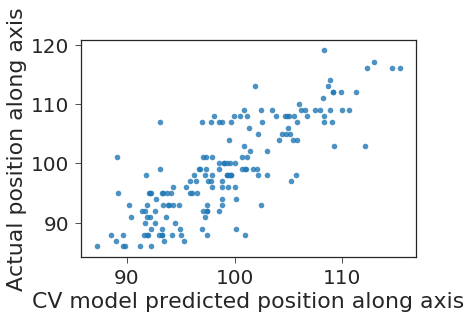

model cv score: r2 =  0.675885977482
running final model
final model fit r2 =  0.876810509326


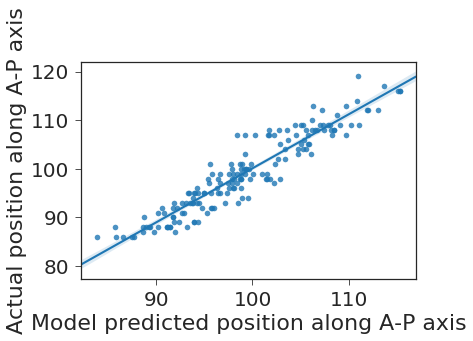

running sanity_check


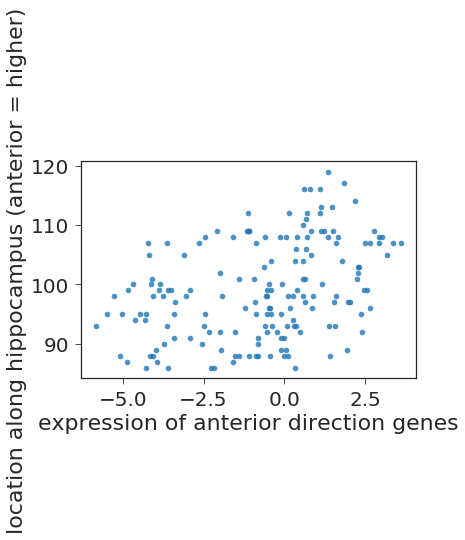

anterior 1 genes vs. y:  r2 = 0.146291960145, p = 2.64362300167e-07 




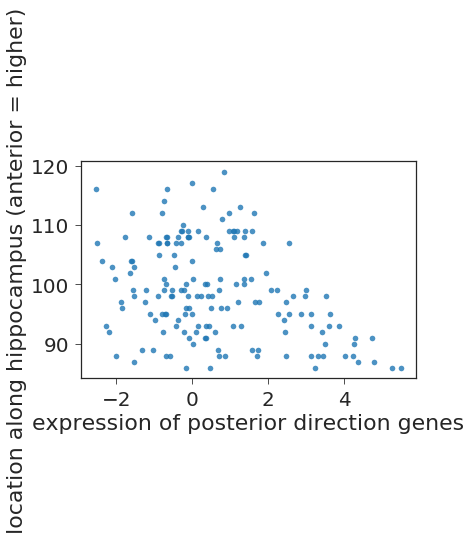

posterior 1 genes vs. y:  r2 = 0.120839023188, p = 3.40674823134e-06 




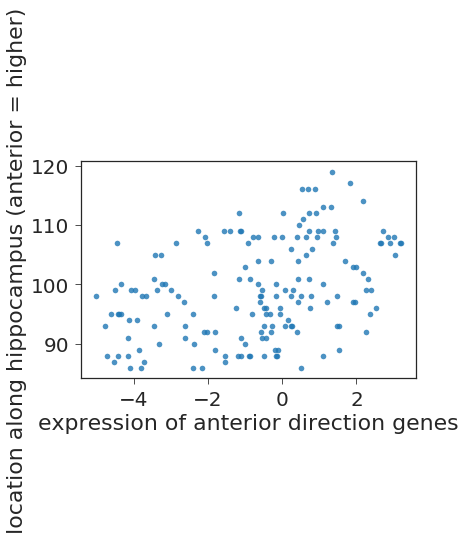

anterior 2 genes vs. y:  r2 = 0.156810463199, p = 9.03376115525e-08 




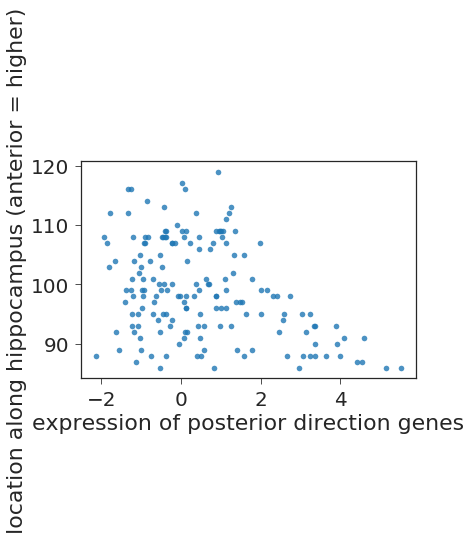

posterior 2 genes vs. y:  r2 = 0.140782455333, p = 4.61980605763e-07 




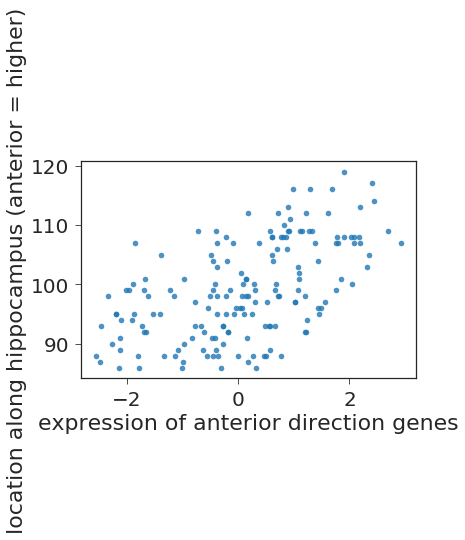

anterior 5 genes vs. y:  r2 = 0.312027641285, p = 2.46628262071e-15 




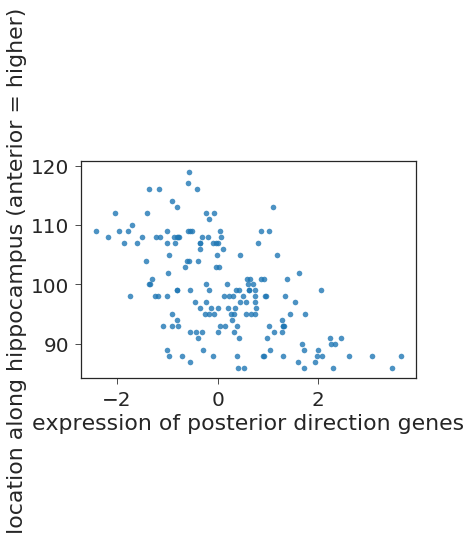

posterior 5 genes vs. y:  r2 = 0.308872084395, p = 3.6401288821e-15 




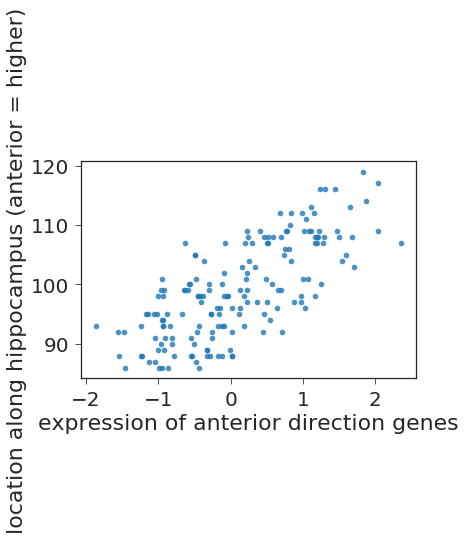

anterior 10 genes vs. y:  r2 = 0.541743338152, p = 2.83625582234e-30 




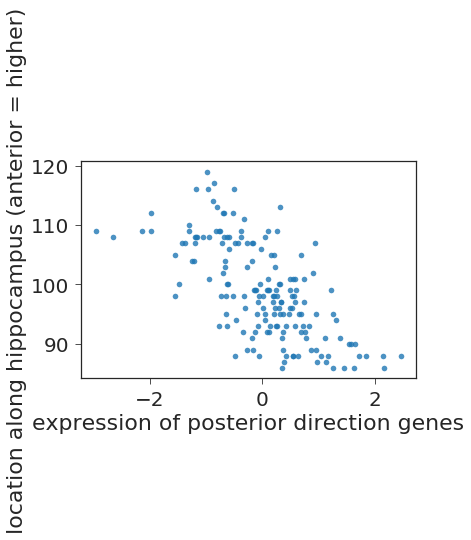

posterior 10 genes vs. y:  r2 = 0.45513306654, p = 6.38206163432e-24 




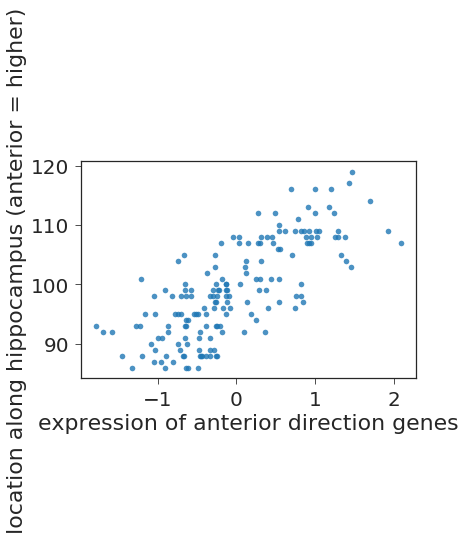

anterior 20 genes vs. y:  r2 = 0.577277974194, p = 3.12395740458e-33 




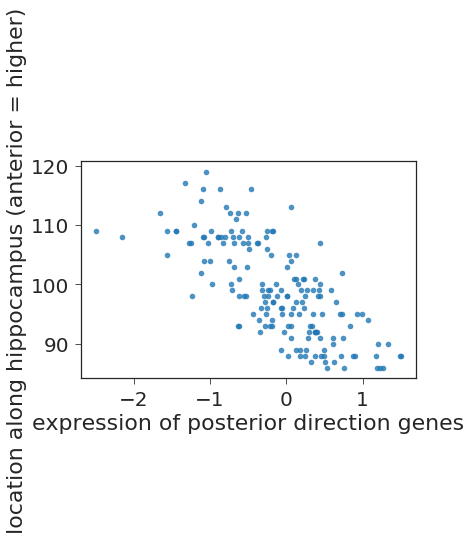

posterior 20 genes vs. y:  r2 = 0.528759540293, p = 3.00011527119e-29 




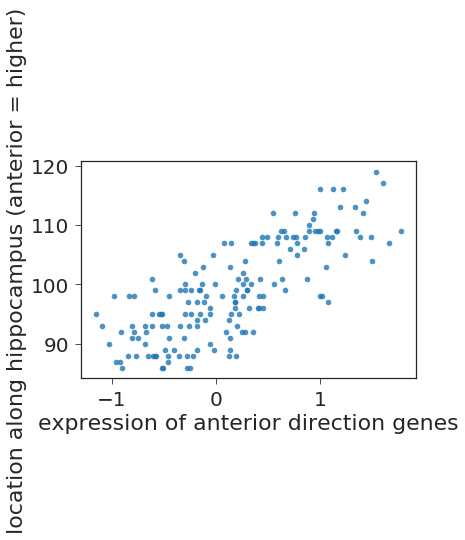

anterior 50 genes vs. y:  r2 = 0.604781566638, p = 1.07277863382e-35 




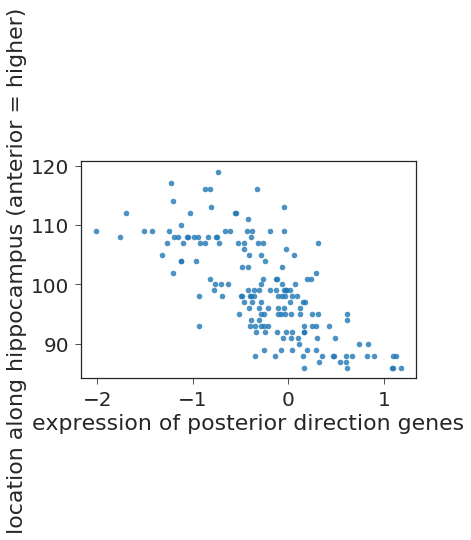

posterior 50 genes vs. y:  r2 = 0.521495808996, p = 1.09169856187e-28 




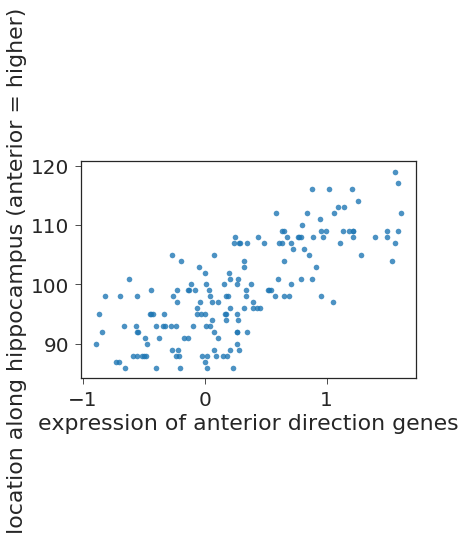

anterior 100 genes vs. y:  r2 = 0.568535370196, p = 1.75686862748e-32 




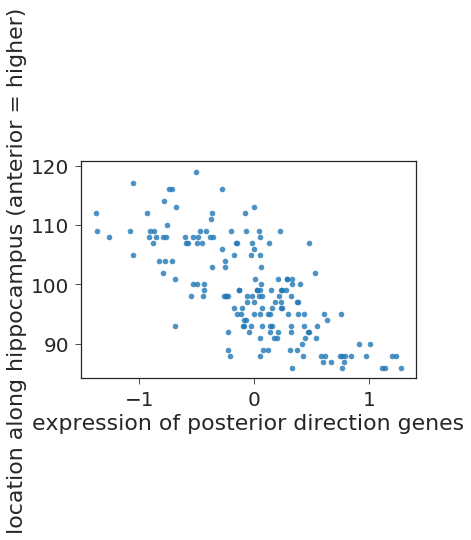

posterior 100 genes vs. y:  r2 = 0.530569444547, p = 2.16785299609e-29 




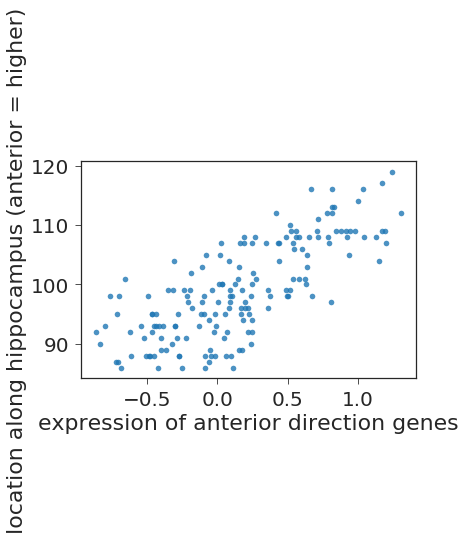

anterior 200 genes vs. y:  r2 = 0.573989954195, p = 6.00589222139e-33 




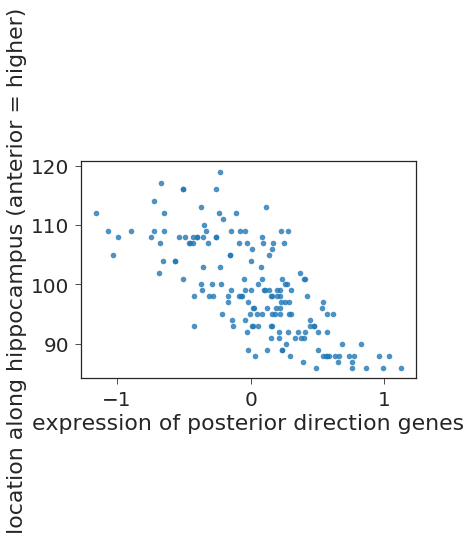

posterior 200 genes vs. y:  r2 = 0.530012749169, p = 2.396015094e-29 




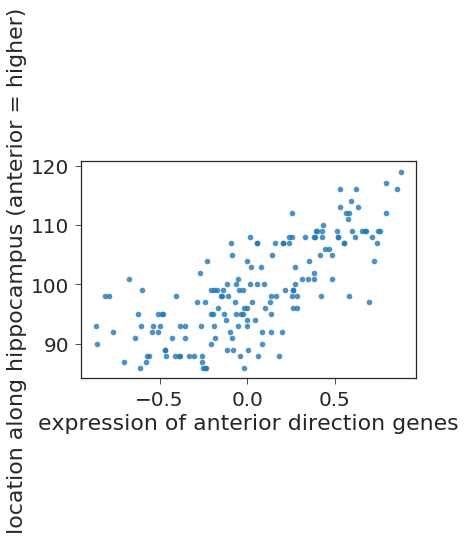

anterior 500 genes vs. y:  r2 = 0.561315373964, p = 7.1262999131e-32 




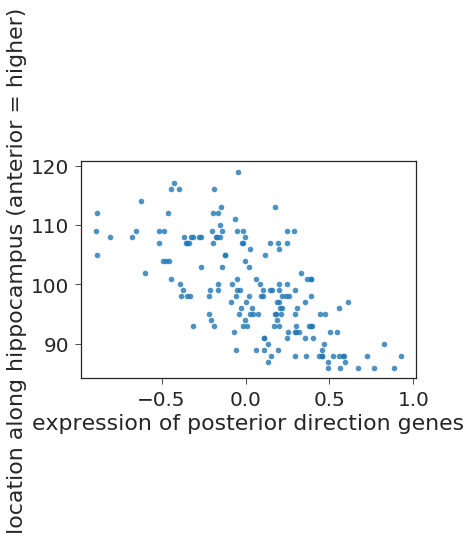

posterior 500 genes vs. y:  r2 = 0.456701046713, p = 5.00149396762e-24 




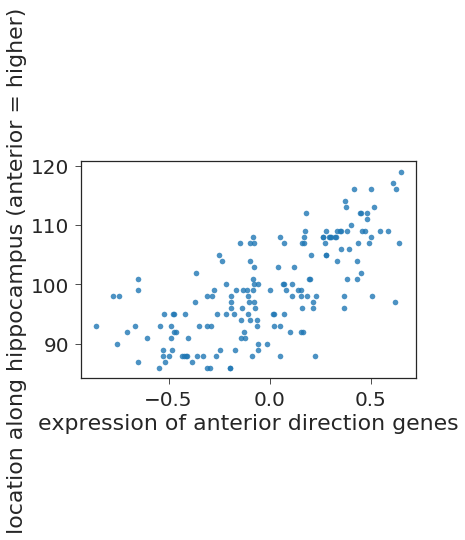

anterior 1000 genes vs. y:  r2 = 0.506219222541, p = 1.5519698984e-27 




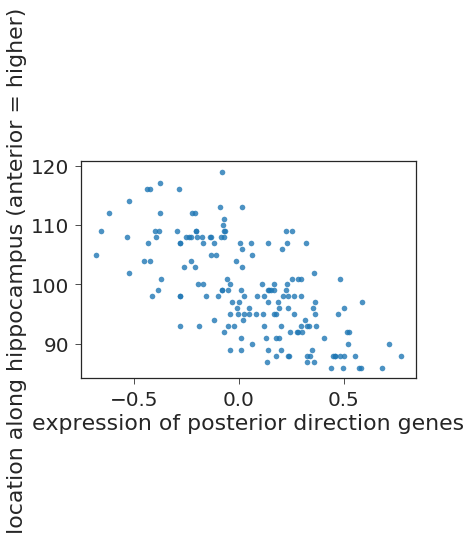

posterior 1000 genes vs. y:  r2 = 0.454418293527, p = 7.13048262374e-24 




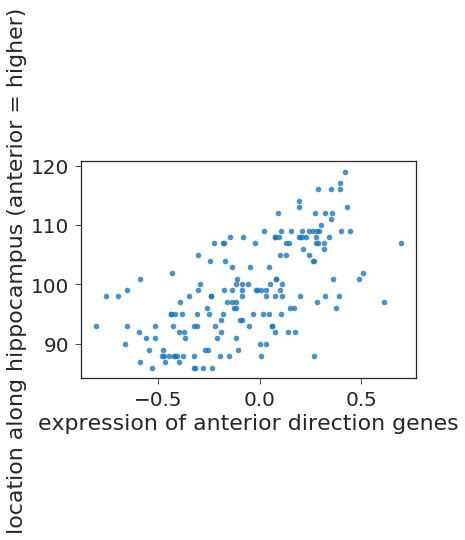

anterior 2000 genes vs. y:  r2 = 0.413582900724, p = 3.20747873988e-21 




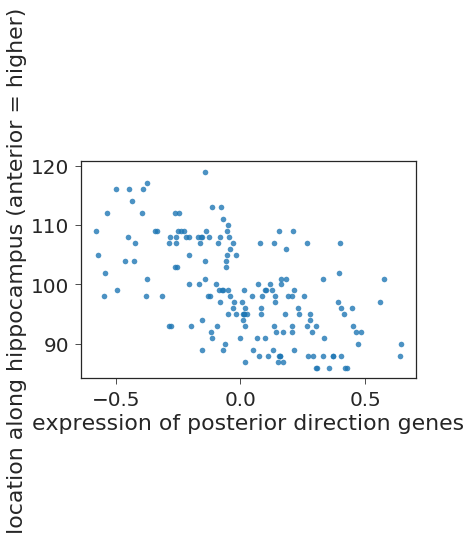

posterior 2000 genes vs. y:  r2 = 0.348659261806, p = 2.35874690133e-17 




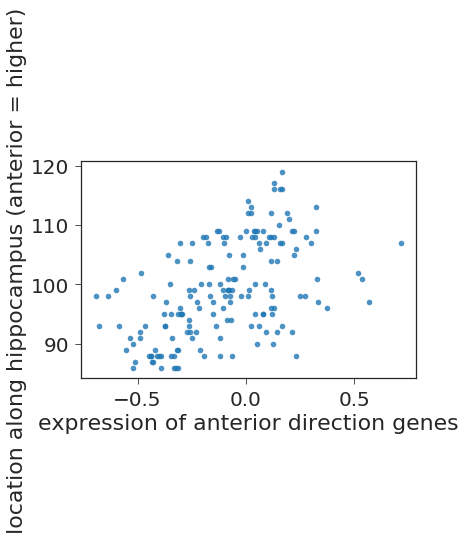

anterior 5000 genes vs. y:  r2 = 0.260250683548, p = 1.19416253845e-12 




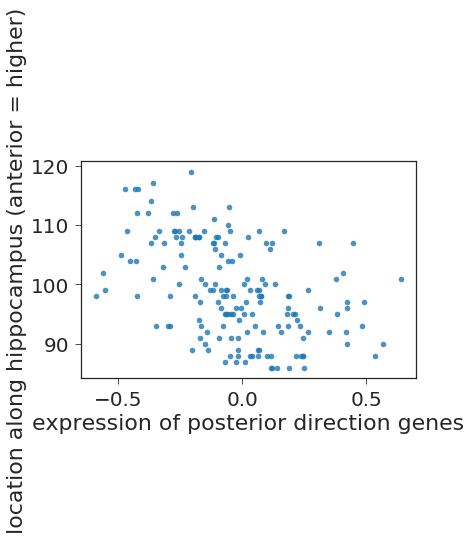

posterior 5000 genes vs. y:  r2 = 0.227039856261, p = 5.09894187119e-11 




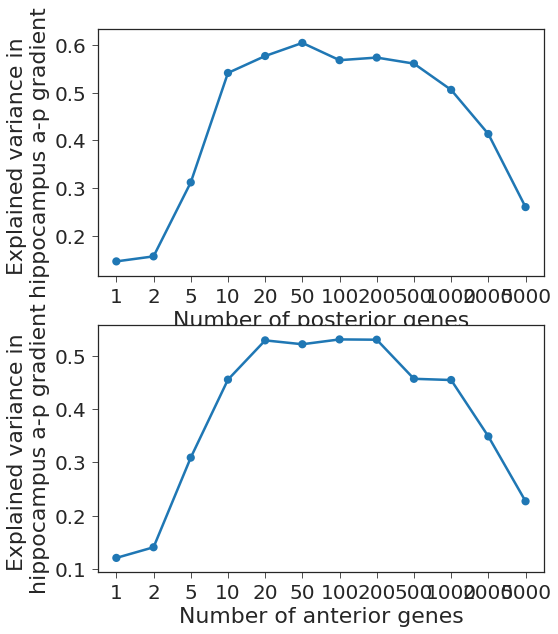

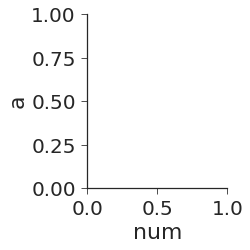

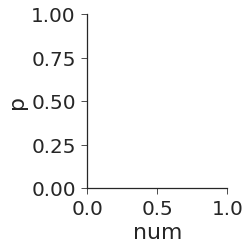

In [773]:
pcalr_out_NEW = PCA_LR_pipeline(xp.values.T, 
                            (df.position_along_hipp_AP_axis), 
                            cv_strategy='score', illustrative=True,
                           test_gene_num = [1, 2, 5, 10, 20, 50, 100, 
                                            200, 500, 1000, 2000, 5000],
                               sanity_check_style = 'separate')

# Cognitive fmri meta-analysis

In [13]:
#OKAY, NOW REPEAT WITH ALL 100 MAPS
metascans = sorted(glob('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/cognition_mri_analysis/all_maps_RI/r*.nii.gz'))
print(len(metascans))
metascans[0]

100


'/home/users/jvogel/Science/Allen_Human_Brain_Atlas/cognition_mri_analysis/all_maps_RI/rv4-topics-100_0_stimulation_somatosensory_tms_pFgA_z_FDR_0_img.nii.gz'

In [1137]:
#metalabs

In [14]:
metalabs = ['T%s_%s_%s_%s'%(os.path.split(x)[-1].split('_')[1],
                         os.path.split(x)[-1].split('_')[3],
                            os.path.split(x)[-1].split('_')[4],
                         os.path.split(x)[-1].split('_')[-5]) for x in metascans]
metares_a = pandas.DataFrame(index=gdf.index,columns = metalabs)
#metares_a.columns = metalabs
metares_a.shape

(3702, 100)

In [15]:
allmetas = image.load_img(metascans).get_data()

In [17]:
col = 'AP_axis_gxp_signature_similarity_SPCR'
#gdf.loc[:,'gvec'] = vec100
#col = 'gvec'
for i,row in gdf.iterrows():
    xs,ys,zs = make_sphere(convert_coords([row['mni_nlin_x'],row['mni_nlin_y'],row['mni_nlin_z']],'xyz'), 3)
    for img in range(allmetas.shape[-1]):
        if allmetas[xs,ys,zs,img].mean() > 0:
            metares_a.loc[i,metalabs[img]] = row[col]
    if i%100 == 0:
        print('finished %s of 3702'%i)

finished 0 of 3702
finished 100 of 3702
finished 200 of 3702
finished 300 of 3702
finished 400 of 3702
finished 500 of 3702
finished 600 of 3702
finished 700 of 3702
finished 800 of 3702
finished 900 of 3702
finished 1000 of 3702
finished 1100 of 3702
finished 1200 of 3702
finished 1300 of 3702
finished 1400 of 3702
finished 1500 of 3702
finished 1600 of 3702
finished 1700 of 3702
finished 1800 of 3702
finished 1900 of 3702
finished 2000 of 3702
finished 2100 of 3702
finished 2200 of 3702
finished 2300 of 3702
finished 2400 of 3702
finished 2500 of 3702
finished 2600 of 3702
finished 2700 of 3702
finished 2800 of 3702
finished 2900 of 3702
finished 3000 of 3702
finished 3100 of 3702
finished 3200 of 3702
finished 3300 of 3702
finished 3400 of 3702
finished 3500 of 3702
finished 3600 of 3702
finished 3700 of 3702


In [18]:
map_sizes = []
for i in range(allmetas.shape[-1]):
    jnk = allmetas[:,:,:,i]
    map_sizes.append(len(jnk[jnk>0]))

In [19]:
del(allmetas)

In [20]:
map_hits = []
for col in metares_a.columns:
    jnk = metares_a[col]
    map_hits.append(len([x for x in jnk.values if pandas.notnull(x)]))

In [21]:
res_sum = pandas.DataFrame(index = metares_a.columns)
res_sum.loc[:,'mean'] = metares_a.mean().values
res_sum.loc[:,'sem'] = metares_a.sem().values
res_sum.loc[:,'map_size'] = map_sizes
res_sum.loc[:,'map_hits'] = map_hits

In [22]:
res_sum.sort_values('mean').head()

,mean,sem,map_size,map_hits
T29_delayed_roi_pFgA,-0.062083,0.007179,1848,20
T93_eyes_movements_pFgA,-0.039965,0.002010,146429,398
T9_attentional_visual_pFgA,-0.032526,0.002561,107198,221
T88_perception_visual_pFgA,-0.032333,0.003025,92493,178
T36_auditory_sensory_pFgA,-0.031379,0.002618,102886,327


In [23]:
cols = ['mean','sem']
for col in cols:
    wtd = (res_sum[col].values * res_sum.map_hits.values
          ) / (res_sum[col].values + res_sum.map_hits.values)
    res_sum.loc[:,'wtd_%s'%col] = wtd

In [24]:
res_sum.sort_values('mean').head()

,mean,sem,map_size,map_hits,wtd_mean,wtd_sem
T29_delayed_roi_pFgA,-0.062083,0.007179,1848,20,-0.062276,0.007177
T93_eyes_movements_pFgA,-0.039965,0.002010,146429,398,-0.039969,0.002010
T9_attentional_visual_pFgA,-0.032526,0.002561,107198,221,-0.032530,0.002561
T88_perception_visual_pFgA,-0.032333,0.003025,92493,178,-0.032339,0.003025
T36_auditory_sensory_pFgA,-0.031379,0.002618,102886,327,-0.031382,0.002618


In [25]:
goodlabs = metares_a.mean().dropna().index
len(goodlabs)
metaresb = metares_a[goodlabs]
metaresb = metaresb[metaresb.mean().sort_values().index]

In [26]:
ATLabs = ['T65','T60','T17','T20','T90']
PMLabs = ['T56','T24','T40','T14','T75']
for top in res_sum.index:
    tnum = top.split('_')[0]
    if tnum in ATLabs:
        res_sum.loc[top,'system'] = 'AT'
    elif tnum in PMLabs:
        res_sum.loc[top,'system'] = 'PM'
res_sum2 = res_sum.loc[metaresb.columns]

In [27]:
goodlabs = res_sum[res_sum.map_hits>100].index
len(goodlabs)
metares100 = metares_a[goodlabs]
metares100 = metares100[metares100.mean().sort_values().index]

In [28]:
res_sum3 = res_sum.loc[metares100.columns]

In [29]:
len(res_sum3)

54

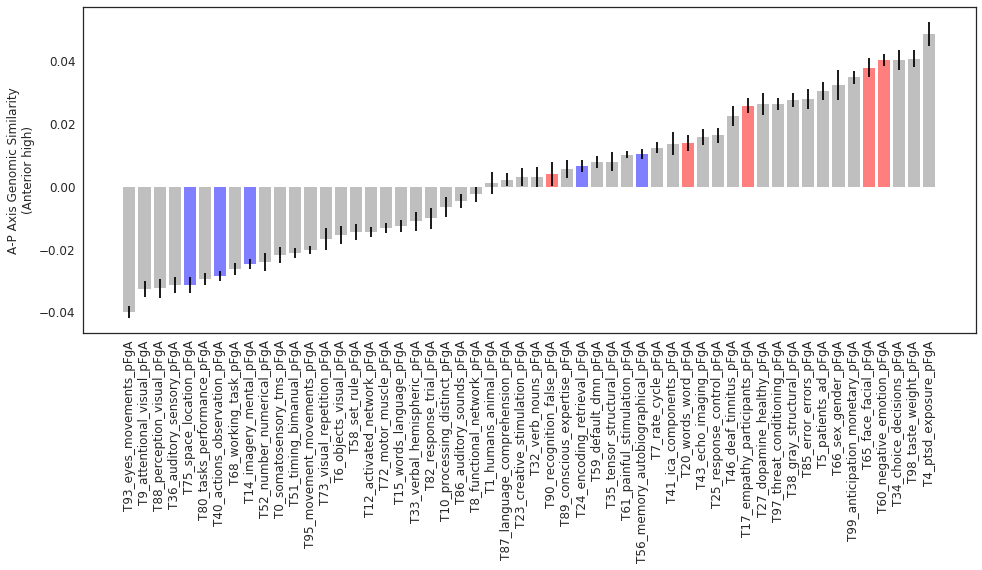

In [30]:
sns.set_context('notebook')
means = metares100.mean().tolist()
stds = metares100.sem().tolist()
cis = [((means[x]-stds[x]),(means[x]+stds[x])) for x in range(len(means))]

# get the range of the confidence interval
#y_r = [means[i] - cis[i][1] for i in range(len(cis))]
#y_r = [cis[i][0] - means[i] for i in range(len(cis))]
y_r = [((cis[i][0] - means[i]) + (means[i] - cis[i][1]))/2 for i in range(len(cis))]

colors = ['red' if res_sum3.loc[x,'system'] == 'AT' else 'blue' if res_sum3.loc[x,'system'] == 'PM' else 'gray' for x in metares100.columns]
plt.close()
sns.set_style('white')
fig, ax = plt.subplots(figsize=(16,6))
fig = plt.bar(range(len(means)), means, yerr=y_r, alpha=0.5, align='center', color = colors,
             )
#plt.xticks(range(len(means)), metares100.mean().dropna().index.tolist())
ax.set_xticks(range(len(means)))
#ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xticklabels(metares100.mean().dropna().index.tolist(), rotation=90)
ax.set_ylabel('A-P Axis Genomic Similarity\n(Anterior high)')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
#plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/COG_2700_s100.pdf')
plt.show()

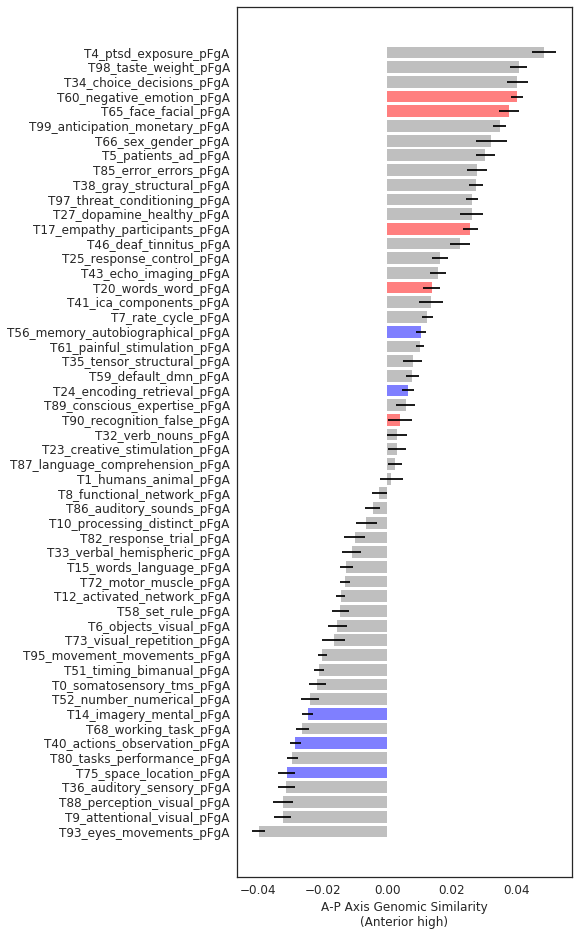

In [471]:
sns.set_context('notebook')
means = metares100.mean().tolist()
stds = metares100.sem().tolist()
cis = [((means[x]-stds[x]),(means[x]+stds[x])) for x in range(len(means))]

# get the range of the confidence interval
#y_r = [means[i] - cis[i][1] for i in range(len(cis))]
#y_r = [cis[i][0] - means[i] for i in range(len(cis))]
y_r = [((cis[i][0] - means[i]) + (means[i] - cis[i][1]))/2 for i in range(len(cis))]

colors = ['red' if res_sum3.loc[x,'system'] == 'AT' else 'blue' if res_sum3.loc[x,'system'] == 'PM' else 'gray' for x in metares100.columns]
plt.close()
sns.set_style('white')
fig, ax = plt.subplots(figsize=(6,16))
fig = plt.barh(range(len(means)), means, xerr=y_r, alpha=0.5, align='center', color = colors,
             )
#plt.xticks(range(len(means)), metares100.mean().dropna().index.tolist())
ax.set_yticks(range(len(means)))
#ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(metares100.mean().dropna().index.tolist())
ax.set_xlabel('A-P Axis Genomic Similarity\n(Anterior high)')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
#plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/COG_ALL_s100.pdf', bbox_inches = 'tight')
plt.show()

In [31]:
goodlabs = res_sum[res_sum.map_hits>400].index
len(goodlabs)
metares300 = metares_a[goodlabs]
metares300 = metares300[metares300.mean().sort_values().index]

In [32]:
res_sum4 = res_sum.loc[metares300.columns]
res_sum4.shape

(27, 7)

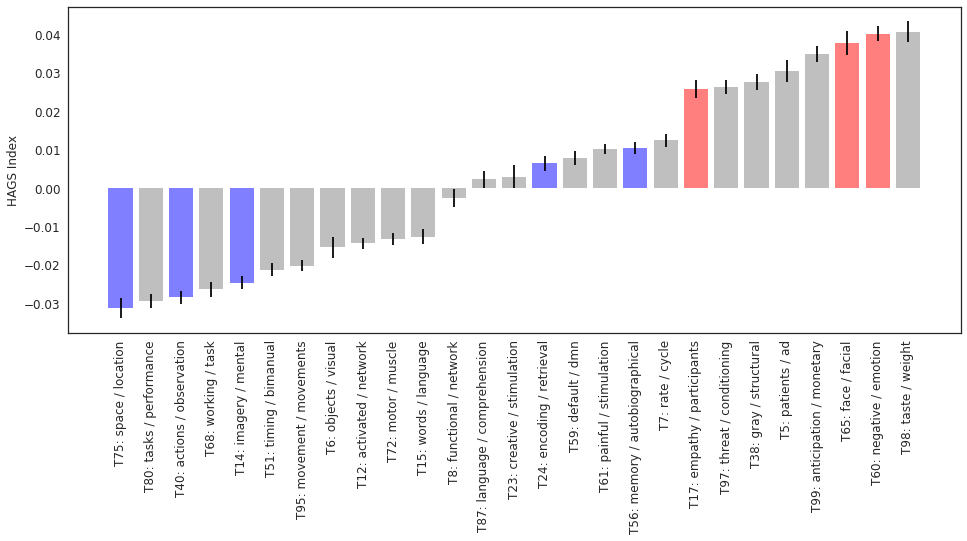

In [33]:
#sns.set_context('notebook',font_scale=2)
means = (metares300.mean()).tolist()
stds = metares300.sem().tolist()
cis = [((means[x]-stds[x]),(means[x]+stds[x])) for x in range(len(means))]
xlabs = ['%s: %s / %s'%(x.split('_')[0],
                x.split('_')[1],
                x.split('_')[2]) for x in metares300.mean().dropna().index.tolist()]

# get the range of the confidence interval
#y_r = [means[i] - cis[i][1] for i in range(len(cis))]
#y_r = [cis[i][0] - means[i] for i in range(len(cis))]
y_r = [((cis[i][0] - means[i]) + (means[i] - cis[i][1]))/2 for i in range(len(cis))]

colors = ['red' if res_sum4.loc[x,'system'] == 'AT' else 'blue' if res_sum4.loc[x,'system'] == 'PM' else 'gray' for x in metares300.columns]
plt.close()
sns.set_style('white')
fig, ax = plt.subplots(figsize=(16,6))
fig = plt.bar(range(len(means)), means, yerr=y_r, alpha=0.5, align='center', color = colors,
             )
#plt.xticks(range(len(means)), metares300.mean().dropna().index.tolist())
ax.set_xticks(range(len(means)))
#ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xticklabels(xlabs, rotation=90)
ax.set_ylabel('HAGS Index')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
#plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/COG_t100_s100_horiz.pdf')
plt.show()

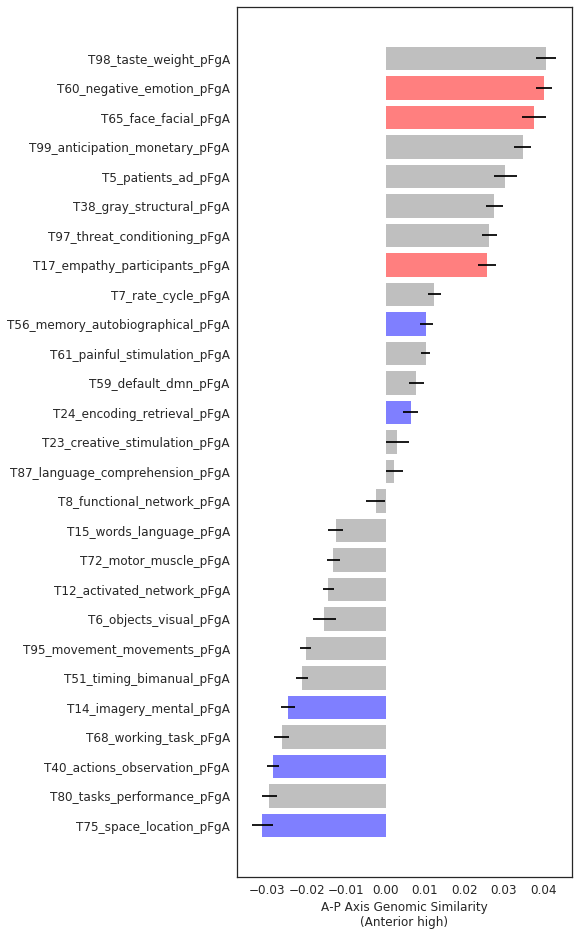

In [475]:
means = (metares300.mean()).tolist()
stds = metares300.sem().tolist()
cis = [((means[x]-stds[x]),(means[x]+stds[x])) for x in range(len(means))]

# get the range of the confidence interval
#y_r = [means[i] - cis[i][1] for i in range(len(cis))]
#y_r = [cis[i][0] - means[i] for i in range(len(cis))]
y_r = [((cis[i][0] - means[i]) + (means[i] - cis[i][1]))/2 for i in range(len(cis))]

colors = ['red' if res_sum4.loc[x,'system'] == 'AT' else 'blue' if res_sum4.loc[x,'system'] == 'PM' else 'gray' for x in metares300.columns]
plt.close()
sns.set_style('white')
fig, ax = plt.subplots(figsize=(6,16))
fig = plt.barh(range(len(means)), means, xerr=y_r, alpha=0.5, align='center', color = colors,
             )
#plt.xticks(range(len(means)), metares300.mean().dropna().index.tolist())
ax.set_yticks(range(len(means)))
#ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(metares300.mean().dropna().index.tolist())
ax.set_xlabel('A-P Axis Genomic Similarity\n(Anterior high)')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
#plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/COG_ALL_s400.pdf', bbox_inches = 'tight')
plt.show()

In [53]:
mni.shape

(182, 218, 182)

In [56]:
ni.load(metascans[0]).shape

(182, 218, 182)

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


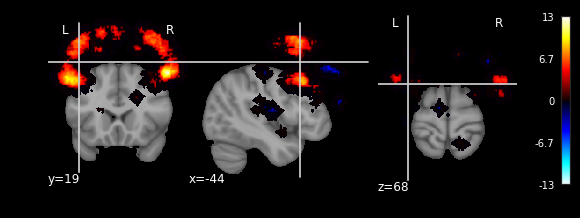

In [57]:
#jnk = ni.Nifti1Image(binmap,affine=ex.affine)
plt.close()
plotting.plot_stat_map(metascans[0], mni)
plt.show()

In [58]:
ex = ni.load(metascans[0])
x,y,z = ex.shape
parcels = []
for i in metares300.mean().index:
    jnk = i.split('_')
    hit = [x for x in metascans if '%s_%s'%(jnk[1],jnk[2]) in x][0]
    binmap = ni.load(hit).get_data()
    binmap[binmap>0] = metares300.mean()[i]
    binmap[binmap<0] = 0
    parcels.append(binmap.reshape(x,y,z,1))
print('concatenating')
concat = np.concatenate(parcels,axis=3)
print('averaging')
mn_map = concat.mean(3)
cog_img = ni.Nifti1Image(mn_map, ex.affine)
cog_img.to_filename('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/cognition_mri_analysis/cog400_allgenes_combonetwork')

concatenating
averaging


In [46]:
cog_img = ni.Nifti1Image(mn_map, ex.affine)
cog_img = image.resample_to_img(cog_img, mni)
cog_img.to_filename('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/cognition_mri_analysis/cog400_allgenes_combonetwork')

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


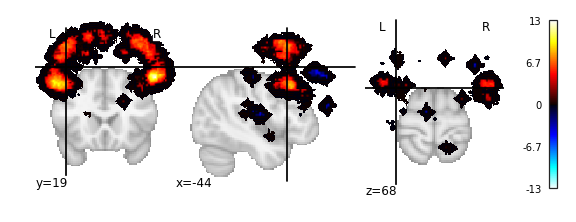

In [45]:
plt.close()
plotting.plot_stat_map(metascans[0])
plt.show()